### Customer Churn Data Generation

- **Customer Data Generation**: The code generates realistic customer data based on various features like `months_as_customer`, `total_purchases`, `avg_order_value`, `support_tickets`, and `last_interaction_days`.

- **Churn Probability Calculation**: Churn probability is calculated based on these features, where customers with certain behaviors are more likely to churn.

- **Saving to CSV**: The generated dataset is saved to a file named `customer_churn_data.csv`.

- **Summary Statistics**: After generating the data, summary statistics (like churn rate and feature descriptions) are printed to give an overview of the dataset.


In [63]:

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Set random seed for reproducibility
np.random.seed(42)

# Number of customers to generate
n_customers = 1000

# Generate customer IDs
customer_ids = range(1001, 1001 + n_customers)

# Generate realistic customer data
def generate_customer_data():
    data = {
        'customer_id': customer_ids,
        'months_as_customer': np.random.randint(1, 60, n_customers),
        'total_purchases': np.random.randint(1, 100, n_customers),
        'avg_order_value': np.random.normal(150, 50, n_customers).round(2),
        'support_tickets': np.random.poisson(2, n_customers),
        'last_interaction_days': np.random.randint(1, 365, n_customers)
    }
    
    # Create correlations to make the data more realistic
    # Customers with higher months_as_customer tend to have more total_purchases
    data['total_purchases'] = (data['total_purchases'] * (data['months_as_customer'] / 30)).astype(int)
    
    # Calculate churn probability based on features
    churn_prob = (
        -0.1 * np.log(data['months_as_customer']) +  # Longer-term customers are less likely to churn
        0.03 * data['last_interaction_days'] +        # More recent interaction means less likely to churn
        -0.02 * data['total_purchases'] +             # More purchases means less likely to churn
        0.01 * (data['support_tickets'] ** 2) +       # More support tickets means more likely to churn
        np.random.normal(0, 0.1, n_customers)         # Add some randomness
    )
    
    # Normalize probabilities
    churn_prob = (churn_prob - churn_prob.min()) / (churn_prob.max() - churn_prob.min())
    
    # Convert to binary churn indicator
    data['churn'] = (churn_prob > 0.7).astype(int)
    
    # Clean up the data
    # Ensure avg_order_value is positive
    data['avg_order_value'] = np.abs(data['avg_order_value'])
    
    # Round average order values to 2 decimal places
    data['avg_order_value'] = data['avg_order_value'].round(2)
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add some missing values to make it more realistic
    mask = np.random.random(n_customers) < 0.05
    df.loc[mask, 'avg_order_value'] = np.nan
    
    return df

# Generate the dataset
df = generate_customer_data()

# Save to CSV
df.to_csv('customer_churn_data.csv', index=False)

# Print summary statistics
print("\nDataset Summary:")
print("-" * 50)
print(f"Total number of customers: {len(df)}")
print(f"Churn rate: {(df['churn'].mean() * 100).round(2)}%")
print("\nFeature Statistics:")
print("-" * 50)
print(df.describe().round(2))

# Print first few rows
print("\nFirst few rows of the dataset:")
print("-" * 50)
print(df.head())


Dataset Summary:
--------------------------------------------------
Total number of customers: 1000
Churn rate: 26.4%

Feature Statistics:
--------------------------------------------------
       customer_id  months_as_customer  total_purchases  avg_order_value  \
count      1000.00             1000.00          1000.00           941.00   
mean       1500.50               30.58            50.89           149.85   
std         288.82               17.02            44.53            48.78   
min        1001.00                1.00             0.00             5.59   
25%        1250.75               16.00            14.00           116.53   
50%        1500.50               31.00            39.00           150.46   
75%        1750.25               45.00            78.00           182.10   
max        2000.00               59.00           182.00           298.25   

       support_tickets  last_interaction_days    churn  
count          1000.00                1000.00  1000.00  
mean      

- The `load_and_explore_data` function reads a CSV file into a DataFrame.
- It prints the shape of the dataset to provide an overview of its size.
- It checks for and displays any missing values in the dataset.
- It provides statistical summaries of the data (mean, standard deviation, etc.).

In [66]:
# Load and explore data


def load_and_explore_data(file_path):
    #load data as df
    df = pd.read_csv(file_path)
    #Exploring df 
    print("Shape of Data:", df.shape)
    print('Null/Missing data:\n', df.isna().sum())
    print("Data Description \n", df.describe())
    data_visualisation(df)
    return df



- The `data_visualisation` function generates a correlation heatmap to visualize relationships between features in the dataset.
- It also creates a pairplot of features by churn, showing distributions and pairwise relationships for each class of churn.


In [69]:
#importing requirements for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
def data_visualisation(df):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df.corr(), annot=True, fmt=".2f")
    plt.title("churn Correlation Heatmap")
    plt.show()
    
    sns.pairplot(df.drop(['customer_id'], axis=1), hue='churn', palette="coolwarm", diag_kind="kde")
    plt.suptitle("Pairplot of Features by Churn", y=1.02)
    plt.show()

- The `preprocess_data` function fills missing values in the `avg_order_value` column with the mean.
- It creates a new feature `days_as_customer` by converting months to days.
- Features are selected by excluding `customer_id` and `churn`, while `churn` is set as the target.
- Numerical features are scaled using `StandardScaler` for improved model performance.


In [72]:
from sklearn.preprocessing import StandardScaler

def preprocess_data(df):
    # Handle missing values by filling mean
    df['avg_order_value'].fillna(df['avg_order_value'].mean(), inplace=True)
    
    # Feature engineering: no. of days as customer 
    df['days_as_customer'] = df['months_as_customer'] * 30

    # Define features and target
    features = df.drop(['customer_id', 'churn'], axis=1)
    target = df['churn']
    
    # scale numerical features using StandardScaler
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(features)
    
    return df_scaled, target

- The `split_df` function splits the features and target into training and testing sets with a 70-30 ratio.

In [75]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

def split_df(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

### Model Training and Evaluation:
- **RandomForestClassifier** is used for its ability to handle complex, non-linear relationships.
- It provides feature importance, which is useful for identifying key factors influencing churn.
- It performs well with outliers and does not require extensive tuning, making it ideal for large datasets.


- Evaluate using **Classification Report** and **Confusion Matrix**.
- Assess accuracy with **5-fold Cross-validation** and print the mean score.
- Return the trained model.


In [78]:
def build_model(X_train, X_test, y_train, y_test):
  #create Random Forest classifier object and fit train values
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Model Evaluation
    y_pred = model.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    
    # Cross-validation score to find the accuracy
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print("Cross-validation Accuracy:", cv_scores.mean())
    
    return model

### `generate_insights` Function

- **Feature Importance:** Analyzes and ranks features based on their impact on churn prediction.
- **Top Features:** Extracts the top 3 most important features.
- **Business Recommendations:** Provides actionable insights for each top feature (e.g., engaging recent customers, resolving support issues).
- **Model Insights:** Helps interpret model behavior in a business context.
- **Error Handling:** Returns an error if feature importance is not available.


In [81]:
def generate_insights(model, df, feature_names):
   #this part gives clear actionable insights from the data and model
    insights = {}

    # Does the model tell us which features matter most?
    if hasattr(model, 'feature_importances_'):
        print("\n Feature importance...")
        
        # Pull out and sort feature importance
        importance = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values(by='Importance', ascending=False)
        
        print("\nWhich features stand out?")
        print(feature_importance_df)

        # Capture top 3 features 
        top_features = feature_importance_df.head(3)
        insights['top_features'] = top_features

        # Practial insights from these importances
        print("\nWhat do these features tell us?")
        recommendations = []
        for _, row in top_features.iterrows():
            if row['Feature'] == 'last_interaction_days':
                recommendations.append(
                    "Attracting customers with less interaction recently can benefit the company. Reach out to them by sharing latest offers to them via call or email or Welcome Back offers."
                )
            elif row['Feature'] == 'support_tickets':
                recommendations.append(
                    "The company needs to resolve recuuring issues by checking the workflow of the team and ensuring better communication with customers."
                )
            elif row['Feature'] == 'months_as_customer':
                recommendations.append(
                    "Provide additional offers to new customers to attract their attention and increase their interaction time with the company. "
                )
        
        # Add recommendations to insights
        insights['recommendations'] = recommendations
        print("\nRecommendations on exploring data:")
        for rec in recommendations:
            print(f"- {rec}")
    else:
         insights['error'] = "Feature importance not available for this model."

    return insights


### Actionable Insights from Feature Importance:
- **Key Features Identified:**
  - The model highlights the most important features affecting churn, including `last_interaction_days`, `support_tickets`, and `months_as_customer`.

- **Top Recommendations:**
  1. **Last Interaction Days:** Reach out to customers with recent interactions via special offers (e.g., "Welcome Back" promotions).
  2. **Support Tickets:** Address recurring issues by improving team workflows and customer communication.
  3. **Months as Customer:** Engage new customers with additional offers to boost retention.

- **Conclusion:** These insights help prioritize strategies for customer retention based on feature importance.


Shape of Data: (1000, 7)
Null/Missing data:
 customer_id               0
months_as_customer        0
total_purchases           0
avg_order_value          59
support_tickets           0
last_interaction_days     0
churn                     0
dtype: int64
Data Description 
        customer_id  months_as_customer  total_purchases  avg_order_value  \
count  1000.000000         1000.000000      1000.000000       941.000000   
mean   1500.500000           30.582000        50.886000       149.851169   
std     288.819436           17.024838        44.530573        48.775279   
min    1001.000000            1.000000         0.000000         5.590000   
25%    1250.750000           16.000000        14.000000       116.530000   
50%    1500.500000           31.000000        39.000000       150.460000   
75%    1750.250000           45.000000        78.000000       182.100000   
max    2000.000000           59.000000       182.000000       298.250000   

       support_tickets  last_interaction_d

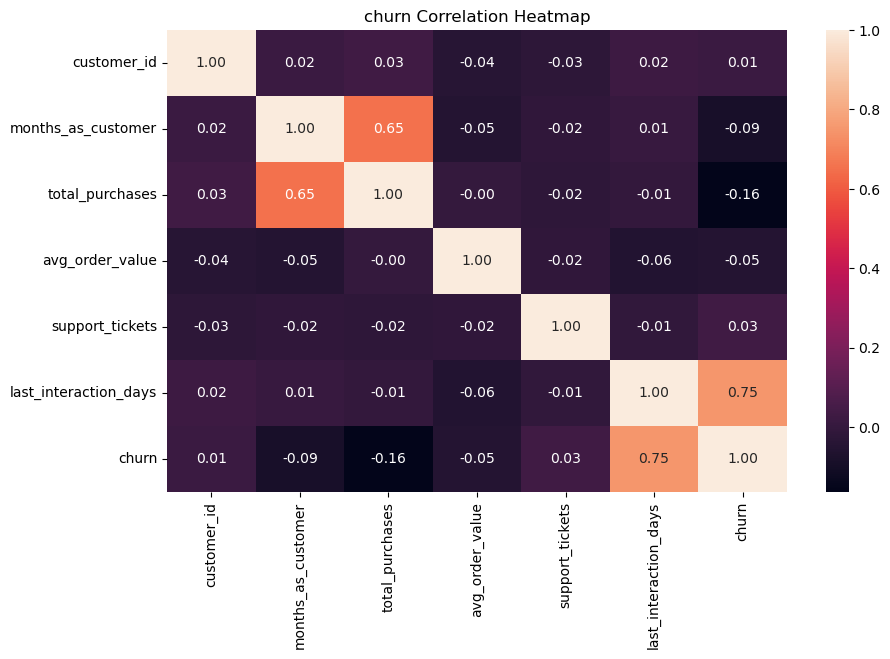

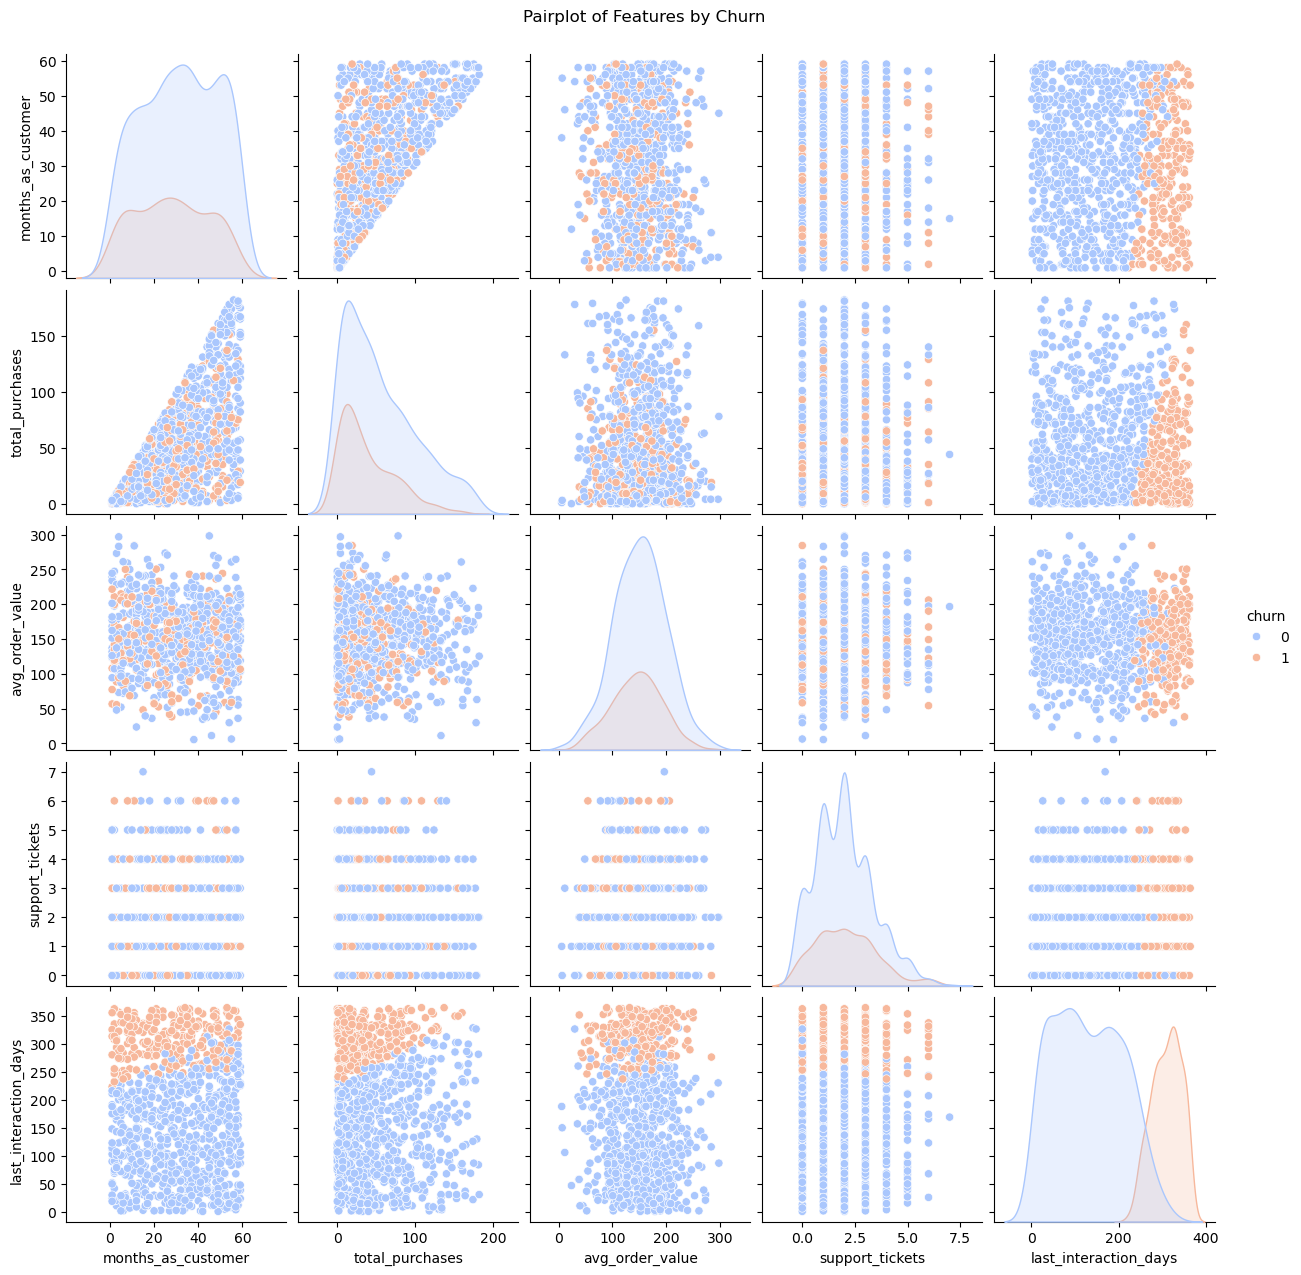

C:\Users\kriti\AppData\Local\Temp\ipykernel_8568\2557460145.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_order_value'].fillna(df['avg_order_value'].mean(), inplace=True)


Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       212
           1       0.99      0.94      0.97        88

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300

Confusion Matrix:
 [[211   1]
 [  5  83]]
Cross-validation Accuracy: 0.9757142857142856

 Feature importance...

Which features stand out?
                 Feature  Importance
4  last_interaction_days    0.799380
1        total_purchases    0.086319
2        avg_order_value    0.036322
0     months_as_customer    0.031815
5       days_as_customer    0.031220
3        support_tickets    0.014944

What do these features tell us?

Recommendations on exploring data:
- Attracting customers with less interaction recently can benefit the company. Reach out to them by sharing latest offers to them via call or email or Welcome Back offers.


In [89]:
def main():
    # Step 1: Load and explore data
    file_path = 'C:\\Users\\kriti\\Desktop\\churn_model\\customer_churn_data.csv'
    df = load_and_explore_data(file_path)
    
    # Step 2: Preprocess data and handle missing values
    features_scaled, target = preprocess_data(df)
    
    # Step 3: Split data
    X_train, X_test, y_train, y_test = split_df(features_scaled, target)
    
    # Step 4: Train model with Random Forest Classifier
    model = build_model(X_train, X_test, y_train, y_test)
    
    # Step 5: Generate insights using Feature Importance
   
    insights = generate_insights(model, df, df.drop(['customer_id', 'churn'], axis=1).columns.tolist())
    # print("Insights:\n", insights)


if __name__ == "__main__":
    main()
